# Demo: Pretraining on a Crowded Starfield

This notebook demonstrates the improvement in BLISS' performance if the encoder model is pretrained on a crowded starfield. Intuitively, the encoder is expected to perform better due to having more opportunities to learn latent properties of light sources from images that are littered with more light sources.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import hydra
import torch
from hydra.utils import instantiate
from matplotlib import pyplot as plt

from bliss.catalog import FullCatalog
from bliss.metrics import BlissMetrics, MetricsMode
from bliss.surveys.sdss import SDSS, PhotoFullCatalog
from bliss.predict import crop_plocs

In [3]:
ra, dec = SDSS.radec_for_rcf(94, 1, 12)

## Generate Disk Datasets for Different Crowding Levels

In [ ]:
MEAN_SOURCES_ARR=((0.06, 0.1, 0.2, 0.5, 0.6))

for mean_sources in ${MEAN_SOURCES_ARR[@]}; do
    ./scripts/generate_data_in_parallel.sh -n 32 -cp ../case_studies/crowded_starfield -cn config "prior.mean_sources=$mean_sources"
done

In [1]:
!du -sh /data/scratch/zhteoh/case_studies/crowded_starfield/data/cached_dataset_mean_sources_0.06

14G	/data/scratch/zhteoh/case_studies/crowded_starfield/data/cached_dataset_mean_sources_0.06


## Pretrain Encoder on Crowded Field

In [ ]:
for mean_sources in ${MEAN_SOURCES_ARR[@]}; do
    bliss -cp ../case_studies/crowded_starfield -cn config 'mode=train' "prior.mean_sources=$mean_sources"
done

## Training Performance

Train an encoder model on default `prior.mean_sources=0.02` dataset, using the pretrained weights from training on the different `prior.mean_sources` datasets.

In [ ]:
bliss -cp ../case_studies/crowded_starfield -cn config_train --multirun

|mean sources|best val loss|||
|---|---|---|---|
|0.06|0.19754|||
|0.1|0.20112|||
|0.2|0.19274|||
|0.5|0.19363|||
|0.6|0.19832|||

## Prediction Performance

Run predictions on real images using best models from each experiment setup.

In [3]:
from os import environ

# set bliss home directory and load config
environ["BLISS_HOME"] = "/data/scratch/zhteoh/case_studies/crowded_starfield"
with hydra.initialize(config_path=".", version_base=None):
    cfg = hydra.compose("config_predict")

In [7]:
from bliss.predict import predict
from omegaconf import OmegaConf

MEAN_SOURCES_ARR = [0.06, 0.1, 0.2, 0.5, 0.6]
experiments = {
    k: {} for k in MEAN_SOURCES_ARR
}
for mean_sources in MEAN_SOURCES_ARR:
    OmegaConf.update(cfg, 'pretrained_mean_sources', mean_sources, force_add=True)
    est_cat = predict(cfg)[0]
    experiments[mean_sources]['est_cat'] = est_cat

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/zhteoh/case-study-crowded-starfield/case_studies/crowded_starfield/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Get predictions for control group

In [9]:
experiments["control"] = {}

control_cfg = cfg.copy()
OmegaConf.update(control_cfg, 'predict.weight_save_path', '${paths.output}/${training.name}/weights_0.02.pt')
experiments["control"]["est_cat"] = predict(control_cfg)[0]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Write out these predictions to a file for later use.

In [13]:
experiments_filepath = "/data/scratch/zhteoh/case_studies/crowded_starfield/experiments.pt"
with open(experiments_filepath, "wb") as f:
    torch.save(experiments, f)

Read in these predictions for use.

In [14]:
experiments_filepath = "/data/scratch/zhteoh/case_studies/crowded_starfield/experiments.pt"
with open(experiments_filepath, "rb") as f:
    experiments = torch.load(f)

In [16]:
def compute_get_metrics(true_cat: FullCatalog, est_cat: FullCatalog, survey_bands: list[int]):
    metrics = BlissMetrics(survey_bands=survey_bands, mode=MetricsMode.FULL)
    return metrics(true_cat, est_cat)

In [29]:
# Get true SDSS photo full catalog
run, camcol, field = SDSS.rcf_for_radec(ra, dec)
sdss = instantiate(
    cfg.surveys.sdss, fields=[{"run": run, "camcol": camcol, "fields": [field]}]
)
photocat_filename = sdss.downloader.download_catalog((run, camcol, field))
img_h, img_w = sdss[0]["image"].shape[1], sdss[0]["image"].shape[2]
photo_true_cat = PhotoFullCatalog.from_file(
    photocat_filename,
    wcs=sdss[0]["wcs"][cfg.simulator.prior.reference_band],
    height=img_h,
    width=img_w,
)

In [33]:
# Hack to crop survey catalog true plocs to match the crop of BLISS' predicted catalog plocs
def crop_true_plocs(cfg, true_plocs):
    ptc = cfg.encoder.tiles_to_crop * cfg.encoder.tile_slen
    w = cfg.predict.crop.width - 2 * ptc
    h = cfg.predict.crop.height - 2 * ptc

    cropped_true_plocs = crop_plocs(cfg, w, h, true_plocs[0], do_crop=True).cpu()

    new_plocs = torch.zeros_like(true_plocs)
    new_plocs[:, : cropped_true_plocs.shape[0], :] = cropped_true_plocs

    return new_plocs

cropped_sdss_true_plocs = crop_true_plocs(cfg, photo_true_cat.plocs)

Plot **uncropped** survey-specific catalog plocs

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(photo_true_cat.plocs[0, :, 1], photo_true_cat.plocs[0, :, 0], s=30, c='r', marker="x")
ax.scatter(experiments["control"]["est_cat"].plocs[0, :, 1], experiments["control"]["est_cat"].plocs[0, :, 0], s=30, c='orange', marker="x")

# add legend
ax.legend(['SDSS', 'Control (est)'], loc='best')

Plot **cropped** survey-specific catalog plocs

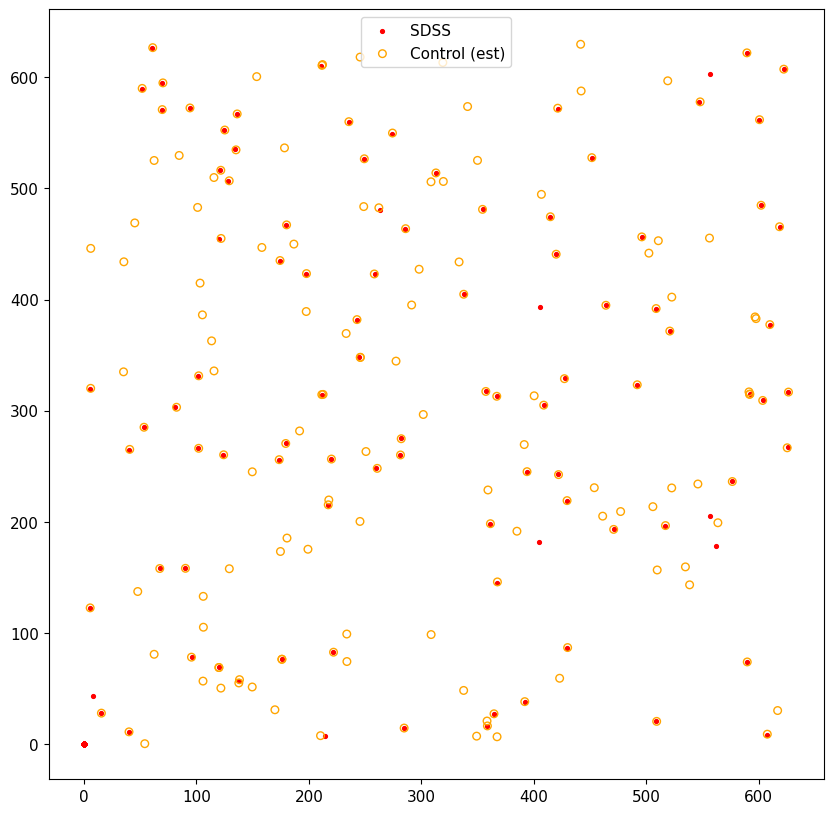

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
# SDSS
ax.scatter(cropped_sdss_true_plocs[0, :, 1], cropped_sdss_true_plocs[0, :, 0], s=30, c='r', marker=".")
ax.scatter(experiments["control"]["est_cat"].plocs[0, :, 1], experiments["control"]["est_cat"].plocs[0, :, 0], s=30, edgecolors='orange', marker="o", facecolors='none')
ax.legend(['SDSS', 'Control (est)'], loc='best')

In [44]:
import copy

def n_sources(true_plocs):
    mask = true_plocs != torch.tensor([0, 0])
    return int(torch.nonzero(mask).shape[0] / 2)

cropped_sdss_true_cat = copy.deepcopy(photo_true_cat)
cropped_sdss_true_cat.plocs = cropped_sdss_true_plocs
cropped_sdss_true_cat.n_sources = torch.tensor([n_sources(cropped_sdss_true_plocs)])

In [51]:
compute_get_metrics(cropped_sdss_true_cat, experiments["control"]["est_cat"], list(range(len(SDSS.BANDS))))

{'detection_precision': 0.4751381278038025,
 'detection_recall': 0.8775510191917419,
 'f1': 0.616487443447113,
 'avg_distance': 2.5956714153289795,
 'avg_keep_distance': 0.296264111995697,
 'gal_tp': 11.0,
 'gal_fp': 7.0,
 'star_tp': 31.0,
 'star_fp': 37.0,
 'class_acc': 0.4883720874786377}

In [52]:
compute_get_metrics(cropped_sdss_true_cat, experiments[0.06]["est_cat"], list(range(len(SDSS.BANDS))))

{'detection_precision': 0.5414012670516968,
 'detection_recall': 0.8673469424247742,
 'f1': 0.6666666865348816,
 'avg_distance': 4.6877121925354,
 'avg_keep_distance': 0.2746175229549408,
 'gal_tp': 8.0,
 'gal_fp': 9.0,
 'star_tp': 34.0,
 'star_fp': 34.0,
 'class_acc': 0.4941176474094391}

In [53]:
compute_get_metrics(cropped_sdss_true_cat, experiments[0.1]["est_cat"], list(range(len(SDSS.BANDS))))

{'detection_precision': 0.5503355860710144,
 'detection_recall': 0.8367347121238708,
 'f1': 0.6639676094055176,
 'avg_distance': 3.435736656188965,
 'avg_keep_distance': 0.30103495717048645,
 'gal_tp': 9.0,
 'gal_fp': 8.0,
 'star_tp': 34.0,
 'star_fp': 31.0,
 'class_acc': 0.5243902206420898}

In [54]:
compute_get_metrics(cropped_sdss_true_cat, experiments[0.2]["est_cat"], list(range(len(SDSS.BANDS))))

{'detection_precision': 0.4969325065612793,
 'detection_recall': 0.8265306353569031,
 'f1': 0.6206896305084229,
 'avg_distance': 4.525688648223877,
 'avg_keep_distance': 0.2728244364261627,
 'gal_tp': 13.0,
 'gal_fp': 6.0,
 'star_tp': 30.0,
 'star_fp': 32.0,
 'class_acc': 0.5308641791343689}

In [55]:
compute_get_metrics(cropped_sdss_true_cat, experiments[0.5]["est_cat"], list(range(len(SDSS.BANDS))))

{'detection_precision': 0.4644808769226074,
 'detection_recall': 0.8673469424247742,
 'f1': 0.6049821972846985,
 'avg_distance': 2.316220760345459,
 'avg_keep_distance': 0.3173627257347107,
 'gal_tp': 11.0,
 'gal_fp': 8.0,
 'star_tp': 32.0,
 'star_fp': 34.0,
 'class_acc': 0.5058823823928833}

In [56]:
compute_get_metrics(cropped_sdss_true_cat, experiments[0.6]["est_cat"], list(range(len(SDSS.BANDS))))

{'detection_precision': 0.4427083432674408,
 'detection_recall': 0.8673469424247742,
 'f1': 0.5862069129943848,
 'avg_distance': 2.070014476776123,
 'avg_keep_distance': 0.28491801023483276,
 'gal_tp': 11.0,
 'gal_fp': 8.0,
 'star_tp': 34.0,
 'star_fp': 32.0,
 'class_acc': 0.529411792755127}

### Detection Results

|Experiment Setup|Control, No Pretrained Weights|Pretraining Configuration|

|Experiment Setup|Control, No Pretrained Weights|`mean_sources=0.06`|`mean_sources=0.1`|`mean_sources=0.2`|
